In [103]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from exact import solve
from policies import FixedPlanPolicy
from mouselab_policy import MouselabPolicy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Define environment

In [105]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=3, sigma=6, quantization=4, cost=1.00, seed=None, branching=[3,1,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            return Categorical([-10, -5, 5, 10])
            #d = Normal(mu, sigma).to_discrete(quantization)
            #return Categorical(map(round, d.vals), d.probs)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

In [106]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env2(mu=0, sigma=4, branching=[3,1,2], cost=1.00, scaling_factors=[1, 1, 1], seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)
    
    def reward(depth):
        if depth > 0:
            x = np.array([-2,-1,1,2])
            vals = mu + sigma * x * scaling_factors[depth-1]
            return Categorical(vals).apply(round)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

# Exact solution

In [107]:
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

def hash_312(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + 
        h(s[2] +
          h(s[3]) +
          h(s[4]))
      ) +
      h(s[5] + 
        h(s[6] +
          h(s[7]) +
          h(s[8]))
      ) + 
      h(s[9] + 
        h(s[10] +
          h(s[11]) +
          h(s[12]))
      )
    )

In [108]:
from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_312)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)

# Simulations

In [51]:
from agents import run_episode
from toolz import get

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env in envs:
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': hash(env),
                       'state': s, 'action': a, 'reward': r}

                
envs = [make_env(mu=3, sigma=6, quantization=4, branching=[2,1,2])
        for _ in range(100)]
df = pd.DataFrame(simulate(optimal_policy, envs))

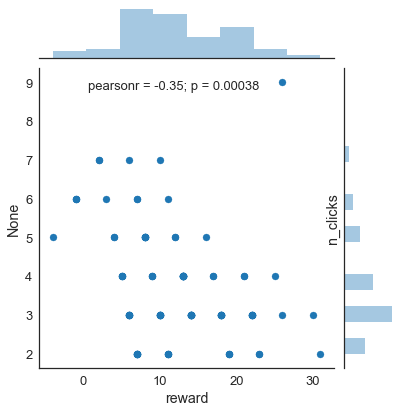

In [54]:
returns = df.groupby('env_id').reward.sum()
n_clicks = df.groupby('env_id').apply(len) - 1
sns.jointplot(returns, n_clicks)
plt.ylabel('n_clicks')

# Save environments to JSON files

## Save trials for Experiment 1

In [195]:
np.random.seed(1)

import json
def env_data(env):
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]
env_type = ''.join(map(str, branch))
envs = [make_env(mu=0, sigma=6, quantization=4, branching=branch)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)


wrote data/experiment_trials/312.json


## Save trials for Experiment 2

In [193]:
np.random.seed(1)

import json
def env_data(env):
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]

sig = 4
scaling_factors_increasing = [1/2,1,6]
env_type='312_2_4_24'

envs = [ make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_increasing)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

wrote data/experiment_trials/312_2_4_24.json


In [194]:
np.random.seed(1)

import json
def env_data(env):
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]

sig = 4
scaling_factors_decreasing = [6,1,1/2]
env_type='312_24_4_2'

envs = [ make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_decreasing)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

wrote data/experiment_trials/312_24_4_2.json


## Move JSON file to experiment directory

In [196]:
%%bash
# This updates the trials for the experiment. Be careful!
cp data/experiment_trials/* ../experiment/experiment/static/json/rewards/

# Compute the LC policy for each of these environments

## Optimal Policy for Experiment 1

In [9]:
pi = dict()
Q = dict()
pi["312_constant_high"] = optimal_policy
Q["312_constant_high"] = optimal_policy.preference

## Optimal Policies for Experiment 2

In [109]:
sig = 4

scaling_factors_increasing = [1/2,1,6]
env_increasing = make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_increasing)
optimal_policy_increasing = get_optimal_policy(env_increasing)

39.9653015137


In [82]:
sig = 4

scaling_factors_decreasing = [6,1,2/1]
env_decreasing = make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_decreasing)
optimal_policy_decreasing = get_optimal_policy(env_decreasing)

36.0519256592


# Inspect LC policies

Log for Experiment 2: 

1. increasing variance, sig = 6, scaling_factors_increasing = [2/3,1,4]: doesn't start by inspecting goals :(
1. increasing variance, sig = 4, scaling_factors_increasing = [1/2,1,6]: 
    * Fraction of trials in which the first click inspected a goal: 1.0
    * Fraction of trials in which only goals were inspected: 0.89
    * Fraction of trials in which a non-goal was inspected before all goals had been inspected: 0.0
    * Avg. number of leafs inspected when non-leafs were inspected: 6.0
    * Avg. number of non-leafs inspected when any nonleafs were inspected: 2.1818181818181817
    * Avg. number of stems inspected when any nonleafs were inspected: 0.18181818181818182
    * Example sequence: [3, 13], [8,4, 13]
1. decreasing variance, sig = 4, scaling_factors_decreasing = [6,1,2/1]
    * Fraction of trials where the first click was a stem: 1.0
    * Fraction of trials in which only immediate outcomes were inspected: 0.0
    * Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: 0.58
    * Avg. number of immediate outcomes inspected when later outcomes were inspected: 2.27
    * Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: 2.21
    * Example sequences: [5, 1, 9, 11, 13] and [9, 1, 3, 5, 13]


## Inspect LC policy for the environment with outward-increasing variance

In [211]:
from agents import run_episode

nr_environments = 10

envs = [make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_increasing) for _ in range(nr_environments)]


nr_levels = 3
nr_branches = 3

leaf_nodes = [3,4,7,8,11,12]
stem_nodes = [1,5,9]
branch_nodes = [2,6,10]
nr_leafs = len(leaf_nodes)

nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12]]

all_leafs= []
not_all_leafs=[]
nr_leafs_inspected = []
nr_nonleafs_inspected = []
nr_stems_inspected = []
nongoal_before_goal = []
first_click_on_goal = np.array([])

click_level = np.array([])
click_nr = np.array([])
observed_value = np.array([])

nonleaf_envs = np.array([])
returns = np.array([])

for env in envs:
    trace = run_episode(optimal_policy_increasing, env)
    returns = np.append(returns,trace['return'])
    
    rewards =env.ground_truth
    clicks = trace['actions'][0:-1]
    
    first_obs = rewards[int(clicks[0])]
    
    n = 0
    for click in trace['actions'][:-1]:
        observed_value = np.append(observed_value,[first_obs])
        n += 1
        for level in range(nr_levels):
            if np.isin(click,nodes_by_depth[level]):
                click_level = np.append(click_level,level+1)
                click_nr = np.append(click_nr,[n])
    
    all_leafs.append(np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    not_all_leafs.append(not np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_leafs_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonleafs_inspected.append(len(trace['actions'][:-1])- nr_leafs_inspected[-1])
    
    if nr_nonleafs_inspected[-1]>0:
        nonleaf_envs = np.append(nonleaf_envs,[env])
    
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    is_goal = np.in1d(trace['actions'][:-1],leaf_nodes)
    first_click_on_goal = np.append(first_click_on_goal,[is_goal[0]])
    if all_leafs[-1]:
        nongoal_before_goal.append(False)
    else:
        first_nongoal = np.where(is_goal == False)
        nongoal_before_goal.append(first_nongoal[0][0]<nr_leafs) 

In [206]:
print(np.mean(returns))
print(np.std(returns))

39.779
13.2713284565


In [198]:
print("Fraction of trials in which the first click inspected a goal: {}".format(np.mean(first_click_on_goal)))
print("Fraction of trials in which only goals were inspected: {}".format(np.mean(all_leafs)))
print("Fraction of trials in which a non-goal was inspected before all goals had been inspected: {}".format(np.mean(nongoal_before_goal)))

all_leafs_array = np.array(all_leafs)
nr_leafs_array = np.array(nr_leafs_inspected)
nr_stems_array = np.array(nr_stems_inspected)
nr_nonleafs_array = np.array(nr_nonleafs_inspected)
np.mean(nr_leafs_array[~all_leafs_array])

print("Avg. Number of leafs inspected: {}".format(np.mean(nr_leafs_array)))

print("Avg. number of leafs inspected when non-leafs were inspected: {}".format(np.mean(nr_leafs_array[~all_leafs_array])))
print("Avg. number of non-leafs inspected when any nonleafs were inspected: {}".format(np.mean(nr_nonleafs_array[~all_leafs_array])))

print("Avg. number of stems inspected when any nonleafs were inspected: {}".format(np.mean(nr_stems_array[~all_leafs_array])))

print(nonleaf_envs[10].ground_truth[leaf_nodes])

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(optimal_policy_increasing, envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 


for n in range(12):
    print("Avg. Level of click {}: {}".format(n+1,np.mean(click_level[click_nr == n+1])))
    

np.mean(click_level[np.logical_and(click_nr == 2, observed_value>0)])

Fraction of trials in which the first click inspected a goal: 1.0
Fraction of trials in which only goals were inspected: 0.88
Fraction of trials in which a non-goal was inspected before all goals had been inspected: 0.0
Avg. Number of leafs inspected: 3.23
Avg. number of leafs inspected when non-leafs were inspected: 6.0
Avg. number of non-leafs inspected when any nonleafs were inspected: 2.1666666666666665
Avg. number of stems inspected when any nonleafs were inspected: 0.25
[ 24.  24.  24. -24.  24. -48.]
Example sequence: 
[7, 4, 3, 8, 11, 12, 6, 13]
[7, 11, 4, 12, 13]
Avg. Level of click 1: 3.0
Avg. Level of click 2: 3.0
Avg. Level of click 3: 3.0
Avg. Level of click 4: 3.0
Avg. Level of click 5: 3.0
Avg. Level of click 6: 3.0
Avg. Level of click 7: 2.0
Avg. Level of click 8: 2.0
Avg. Level of click 9: 1.75
Avg. Level of click 10: 1.0
Avg. Level of click 11: nan
Avg. Level of click 12: nan


/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3.0

In [29]:
1+1

2

## Inspect Policy for environment with decreasing variance

In [209]:
nr_environments = 100

envs = [make_env2(mu=0, sigma=sig, branching=[3,1,2], cost=1.00, scaling_factors=scaling_factors_decreasing) for _ in range(nr_environments)]

nr_levels = 3
nr_branches = 3

leaf_nodes = [3,4,7,8,11,12]
stem_nodes = [1,5,9]
branch_nodes = [2,6,10]
nr_leafs = len(leaf_nodes)

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []
started_with_stem = np.array([])
started_with_leaf = np.array([])

click_level = np.array([])
click_nr = np.array([])
observed_value = np.array([])
observations = np.array([])

obs_before_first_leaf =np.array([])

returns = np.array([])

for env in envs:
    trace = run_episode(optimal_policy_decreasing, env)
    returns = np.append(returns,trace['return'])
    
    rewards =env.ground_truth
    clicks = trace['actions'][0:-1]
    
    first_obs = rewards[int(clicks[0])]
    
                
    started_with_stem = np.append(started_with_stem, [np.in1d(trace['actions'][0],stem_nodes)])
    started_with_leaf = np.append(started_with_leaf, [np.in1d(trace['actions'][0],leaf_nodes)])
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        obs_before_first_leaf = np.append(obs_before_first_leaf,[rewards[clicks[first_nonimmediate[0][0]-1]]])
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes))
        
    n = 0
    for click in clicks:
        observed_value = np.append(observed_value,[first_obs])        
        observations = np.append(observations,[rewards[int(click)]])

        n += 1
        for level in range(nr_levels):
            if np.isin(click,nodes_by_depth[level]):
                click_level = np.append(click_level,level+1)
                click_nr = np.append(click_nr,[n])
    
    
    

In [210]:
print(np.mean(returns))
print(np.std(returns))

34.49
21.0648973413


In [191]:
print("Fraction of trials where the first click was a stem: {}".format(np.mean(started_with_stem)))
#print(np.mean(started_with_leaf))

print("Fraction of trials in which only immediate outcomes were inspected: {}".format(np.mean(all_stems)))
print("Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: {}".format(np.mean(nonstem_before_stem)))

print("Average second level if the first observation was 48: {}".format(np.mean(click_level[np.logical_and(click_nr == 2, observed_value==48)])))
print("Average second level if the first observation was less than 48: {}".format(np.mean(click_level[np.logical_and(click_nr == 2, observed_value<48)])))
#print("Average second level if the first observation was negative: {}".format(np.mean(click_level[np.logical_and(click_nr == 2, observed_value<0)])))

all_stems_array = np.array(all_stems)
nr_stems_array = np.array(nr_stems_inspected)
nr_nonstems_array = np.array(nr_nonstems_inspected)
#np.mean(nr_stems_array[~all_stems_array])

print("Avg. number of immediate outcomes inspected when later outcomes were inspected: {}".format(np.mean(nr_stems_array[~all_stems_array])))
print("Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: {}".format(np.mean(nr_nonstems_array[~all_stems_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(optimal_policy_decreasing, envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

for n in range(12):
    print("Avg. Level of click {}: {}".format(n+1,np.mean(click_level[click_nr == n+1])))
    
    
np.mean(obs_before_first_leaf[np.logical_and(np.array(nr_stems_inspected)==2, observed_value<0)]==48)

Fraction of trials where the first click was a stem: 1.0
Fraction of trials in which only immediate outcomes were inspected: 0.0
Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: 0.492
Average second level if the first observation was 48: 3.0
Average second level if the first observation was less than 48: 1.0
Avg. number of immediate outcomes inspected when later outcomes were inspected: 2.45
Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: 2.148
Example sequence: 
[9, 5, 1, 4, 3, 13]
[1, 3, 4, 13]
Avg. Level of click 1: 1.0
Avg. Level of click 2: 1.506
Avg. Level of click 3: 1.9133689839572192
Avg. Level of click 4: 2.467654986522911
Avg. Level of click 5: 2.602536997885835
Avg. Level of click 6: 2.893719806763285
Avg. Level of click 7: 2.641025641025641
Avg. Level of click 8: 2.7662337662337664
Avg. Level of click 9: 2.8275862068965516
Avg. Level of click 10: 2.727272727272

ValueError: operands could not be broadcast together with shapes (1000,) (4598,) 

## Predictions for Experiment 2

*Outwardly inceasing variance:*
1. The first click(s) should always fall on leaf nodes. 
1. Participants should never inspect a non-leaf before all leafs have been inspected.
1. When a leaf with value +48 is discovered then that path is taken immediately.
1. Non-leafs should only be inspected if there is a tie between the best leaf values.
1. The first non-leaf the strategy inspects is at the second level and belongs to one of the best paths.



*Outwardly deceasing variance:*
1. In the condition with outwardly decreasing variance the first click should always fall on the first level.
1. If the first observation is less than 48, then the second click should remain on level 1.
1. If the first observation is 48, then the second click should be on a leaf of the same branch.


## Inspect policies for the environment with constant high variance

In [10]:
from policies import SoftmaxPolicy
from agents import run_episode

nr_environments = 1000

envs = [make_env(mu=3, sigma=6, quantization=4, branching=[3,1,2]) for _ in range(nr_environments)]

leaf_nodes = [3,4,7,8,11,12]
stem_nodes = [1,5,9]
branch_nodes = [2,6,10]


nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_branch_nodes_inspected = []
nr_leaf_nodes_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations = []

nr_observations_by_branch = np.empty([nr_environments,4])

e=0
for env in envs:
    
    trace = run_episode(pi["312_constant_high"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_leaf_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))
    
    
    
    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    e+=1

The average number of observations was 5.38.
0.0
0.56
0.3545
nan
nan
nan
Example sequence: 
[10, 12, 11, 13]
[ 0.     0.167  0.167  0.     0.     0.167  0.167  0.     0.     0.167  0.167  0.     0.     0.   ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.5  0. ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


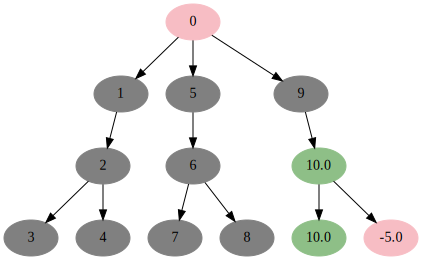

In [49]:
import time
print("The average number of observations was %.2f." % np.mean(nr_observations))

print(np.mean(all_stems))
print(np.mean(nr_stems_inspected)/len(stem_nodes))
print(np.mean(nr_leaf_nodes_inspected)/len(leaf_nodes))


print(np.mean(np.amax(nr_observations_by_branch,1)))
print(np.mean(np.amin(nr_observations_by_branch,1)))
print(np.mean(np.amax(nr_observations_by_branch,1)-np.amin(nr_observations_by_branch,1)))


print("Example sequence: ")
env = envs[10]

trace = run_episode(pi["312_constant_high"], env)

print(trace['actions'])
env.reset()

env.render()

t=0
for a in trace['actions'][0:-1]:
    env.step(a)
    print(pi["312_constant_high"].action_distribution(trace['states'][t]))
    env.render()
    #time.sleep(2)
    t+=1
env.render()
#print(trace['actions']) 

#np.save('data/case_study5.npy','env')

In [124]:
nr_environments = 10000

envs = [make_env(mu=3, sigma=6, quantization=4, branching=[3,1,2]) for _ in range(nr_environments)]


final_term_reward = []
nr_observations = []
traces = []
for env in envs[0:1000]:

    #agent = Agent()
    #agent.register(LC_policies['binary_tree_constant_high'])
    #agent.register(env)
    trace = run_episode(pi["312_constant_high"], env)
    traces.append(trace)
    #print(trace['actions'])
    
    env.reset()
    t=0
    for a in clicks:
        env.step(a)
        #print(LC_policies['constant_high'].action_distribution(trace['states'][t]))
        #env.render()
        t+=1
    nr_obs = len(trace['actions'])-1    
    #print(nr_obs)
    state = trace['states'][t]
    #print(state)
    term_reward = env.expected_term_reward(state)
    #print(term_reward)
    final_term_reward.append(term_reward)
    nr_observations.append(nr_obs)
    
term_rewards_array = np.array(final_term_reward)
nr_obs_array = np.array(nr_observations)

traces_array = np.array(traces)

less_than_three = np.where(nr_obs_array<3)[0]
not_all_pruned = np.logical_or(np.less(term_rewards_array, 5), np.greater(term_rewards_array, 6))
#print(trace['actions'][0:-1])
#print(trace['actions'])
print(traces_array[less_than_three[1]]['states'][-2])
print(term_rewards_array[less_than_three[1]])
print(env.expected_term_reward(traces_array[less_than_three[1]]['states'][-2]))

#print(not_all_pruned)

#print(env.expected_term_reward(trace['states'][t]))

NameError: name 'pi' is not defined

In [50]:
print(np.min(nr_obs_array))

for i in np.linspace(2,12,11):
   #print("The minimum expected terminal reward upon stopping after inspecting {} nodes was {}".format(i,np.mean(term_rewards_array[np.logical_and(not_all_pruned,nr_obs_array==i)]))) 
   print("The minimum expected terminal reward upon stopping after inspecting {} nodes was {}".format(i,np.min(term_rewards_array[nr_obs_array==i]))) 
#vals = np.linspace(-12+3, 12+3, 6)
#delta = vals[1] - vals[0]
#bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
#print(bins)

2
The minimum expected terminal reward upon stopping after inspecting 2.0 nodes was 20.0
The minimum expected terminal reward upon stopping after inspecting 3.0 nodes was 10.0
The minimum expected terminal reward upon stopping after inspecting 4.0 nodes was 10.0
The minimum expected terminal reward upon stopping after inspecting 5.0 nodes was 5.0
The minimum expected terminal reward upon stopping after inspecting 6.0 nodes was 0.0
The minimum expected terminal reward upon stopping after inspecting 7.0 nodes was 0.0
The minimum expected terminal reward upon stopping after inspecting 8.0 nodes was -5.0
The minimum expected terminal reward upon stopping after inspecting 9.0 nodes was -5.0
The minimum expected terminal reward upon stopping after inspecting 10.0 nodes was -10.0
The minimum expected terminal reward upon stopping after inspecting 11.0 nodes was -5.0
The minimum expected terminal reward upon stopping after inspecting 12.0 nodes was -10.0


## Case Study Protocols

### Case Study 1

### Case Study 2

### Case Study 3

### Case study 4

## Conclusion

In the 3-1-2 tree with a uniform reward distribution all of the click sequences appear to be compatible with best-first search that starts with a non-leaf and continues to inspect non-leafs until it identifies a promising branch. Concretely, it jumps to inspecting the leafs when it finds a branch whose EV is at least 10 higher than the EV of any other branch. 

If it switches the branch after having fully explored one branch, it starts from the root or stem.  This strategy does not prune. It will return to a branch where it observed the largest loss after having found that the expected value of paths on other brranches are all negative.

This strategy has a decaying aspiration level. The more information has been already observed, the lower its aspiration level is.


This strategy is clearly distinct from traditional search strategies except for best-first search:

* It is distinct from breadth first search in that it will continue to explore the same branch if the node(s) observed on it are promising.
* It is distinct from depth-first search in that hops from branch to branch unless the observed value on a branch was really good.
* It doesn’t do backward search because it prefers nodes that are informative about multiple paths and leaf nodes are informative about only one single path.
* Unlike classic best-first search, it skips to the leafs of the tree when the branch's EV is 10 points higher than that of any other branch.
* It might have a satisficing component to it.

## Qualitative predictions

1. The first observed node is a stem node.
1. Observe at least two pieces of information.
1. If the observed value is below average (-5 or -10) then they should switch to a different branch, but if the observed value is above average (+5 or +10) then they should inspect another node on the same branch.
1. If the first observed node is a non-leaf and its revealed value is positive but small (+5), then people should inspect a another non-leaf on the same branch, and if its revealed value is large and positive (+10), then people should inspect a leaf on the same branch. 
1. People should always inspect a node that lies on a path with maximal expected return.
1. Once one branch has an expected return that is at least 10 points larger than the expected return of any other branch people should skip to inspecting its leafs even if it has uninspected branch or stem nodes.
1. The satisficing level starts out very high (>20 after 1 click and 20 after two clicks) and then decays as additional clicks are made (10 after 3 clicks, -5 after 11 clicks). Therefore, the smallest expected reward with which a person stops whould be decreasing with the number of clicks.


## Inspect policy for the environment with constant low variance

In [112]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"binary_tree_constant_low")

leaf_nodes = [2,3,5,6]
stem_nodes = [1,4]
#branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations_by_branch = np.empty([nr_environments,2])

nr_observations = []
first_observation = []

e=0
for env in envs:
    trace = run_episode(LC_policies["binary_tree_constant_low"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    first_observation.append(trace['states'][1][trace['actions'][0]])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))    
    e+=1
        

In [113]:
np.max(nr_observations_by_branch[:,0:1])

3.0

In [114]:
first_observations_array = np.array(first_observation)
nr_observations_array = np.array(nr_observations)

print("The average number of observations was %.2f." % np.mean(nr_observations))

print("The maximum number of observations was {}".format(np.amax(nr_observations)))
print("The minimum number of observations was {}".format(np.amin(nr_observations)))

print("maximum number of observations on the same branch: {}".format(np.max(nr_observations_by_branch[:,0:1])))

print("Avg. first observation that led to termination: {}".format(np.mean(first_observations_array[nr_observations_array==1])))
print("Avg. first observation that led to continuation: {}:".format(np.mean(first_observations_array[nr_observations_array==2])))


#print("Zero observations: %.2f. percent" % 100*np.mean(np.equal(np.array(nr_observations),np.zeros([1000,1]))))
#print("One observation: %.2f. percent" % 100*np.mean(np.array(nr_observations)==1))
#print("Two observations: %.2f. percent" % 100*np.mean(np.array(nr_observations)==2))


print("Example sequence: ")
env=envs[0]
env.reset()
trace = run_episode(LC_policies["binary_tree_constant_low"], env)
print(trace['actions']) 


env.reset()
for a in trace['actions'][0:-1]:
    env.step(a)
    env.render() 



The average number of observations was 1.79.
The maximum number of observations was 6
The minimum number of observations was 1
maximum number of observations on the same branch: 3.0
Avg. first observation that led to termination: 2.3527559055118106
Avg. first observation that led to continuation: -2.8876080691642656:
Example sequence: 
[4, 7]


# Measure the performance and number of clicks of the LC policies

In [124]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

term_action = 7

def eval_envs(cost, env_type, envs):
    policies = {
        'BO': LC_policies[env_type],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                df['env_type'] = env_type
                yield df
    return pd.concat(loop())


envs_per_type = 1000
chunks_per_job = 5
total_envs = envs_per_type * len(environments)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)

environments=['binary_tree_increasing','binary_tree_constant_low','binary_tree_constant_high']
#environments=['binary_tree_increasing']

cost = 1.00
jobs = [delayed(eval_envs)(cost, env_type, envs) 
        for env_type in environments
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost, envs_per_type,None, env_type))]
result = Parallel(n_job)(tqdm(jobs))

#Save results
results = pd.concat(result)
np.save('data/results_binary_trees.npy',results)


100%|██████████| 132/132 [00:22<00:00,  5.75it/s]

## Inspect the results

In [125]:
import pandas as pd
import numpy as np

#results=pd.DataFrame(np.load('data/results_binary_trees.npy'),columns=[''])

#results = np.load('data/results_variance_structures.npy')
#df = pd.DataFrame(list(results.item().iteritems()), columns=['agent','util','cost','env_type'])

#LC_policies.to_pickle('data/LC_policies_backward_planning.pkl')

#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','env_type']).util.mean())
print(results.groupby(['agent','env_type']).observations.mean())

#results

#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

agent             env_type                 
BO                binary_tree_constant_high    19.834867
                  binary_tree_constant_low      0.343407
                  binary_tree_increasing       16.726953
full-observation  binary_tree_constant_high    19.664000
                  binary_tree_constant_low     -2.148000
                  binary_tree_increasing       14.504000
none              binary_tree_constant_high    -0.148000
                  binary_tree_constant_low     -0.039600
                  binary_tree_increasing        0.072000
Name: util, dtype: float64
agent             env_type                 
BO                binary_tree_constant_high    4.740333
                  binary_tree_constant_low     1.794833
                  binary_tree_increasing       3.013367
full-observation  binary_tree_constant_high    6.000000
                  binary_tree_constant_low     6.000000
                  binary_tree_increasing       6.000000
none              binary_tree_consta

,observations,util,env,agent,cost,env_type
0,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
1,4,3.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
2,6,-16.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
3,4,36.800000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
4,1,27.000000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
5,6,-11.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
6,1,20.600000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
7,2,24.400000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
8,4,4.266667,<MouselabEnv instance>,BO,1.0,binary_tree_increasing
9,6,-13.200000,<MouselabEnv instance>,BO,1.0,binary_tree_increasing


In [55]:
results

,0,1,2,3,4,5
0,3,23.4,<MouselabEnv instance>,BO,1,increasing
1,4,24,<MouselabEnv instance>,BO,1,increasing
2,10,2,<MouselabEnv instance>,BO,1,increasing
3,8,18.4,<MouselabEnv instance>,BO,1,increasing
4,6,22,<MouselabEnv instance>,BO,1,increasing
5,10,2,<MouselabEnv instance>,BO,1,increasing
6,2,24.4,<MouselabEnv instance>,BO,1,increasing
7,3,25,<MouselabEnv instance>,BO,1,increasing
8,10,2,<MouselabEnv instance>,BO,1,increasing
9,5,21.4,<MouselabEnv instance>,BO,1,increasing
